# Chicago crime dataset analysis
---

In this notebook,We are using Spark, Pandas, Matplotlib, Seaborn to predict the crime type based on other variables.

. The point is:

 * Perform data reading, transforming, and querying using Apache Spark
 * Visualize using existing Python libraries. Matplotlib will remain when I know to do with it all that I'm currenly using Seaborn for.
 * Where interoperation between Spark and Matplotlib is a hindrance, I use Pandas and Numpy.
 * MLlib Library
 * SparkQL

---

## Get Imports out of the way



Spark imports

In [1]:
## spark imports
from pyspark.sql import Row, SparkSession
import pyspark.sql.functions as F

Standard python data analysis imports

In [2]:
## standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Jupyter visualization options

In [2]:
%matplotlib inline

#Not too sure the following 2 work. This is a TODO
sns.set_color_codes("pastel")
plt.rcParams["figure.figsize"] = [20, 8]

In [3]:
# Import PySpark
import pyspark
from pyspark.sql import SparkSession

#Create SparkSession
spark = SparkSession.builder.getOrCreate()
#conf = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'),('spark.driver.memory','8g')])

#sc = pyspark.SparkContext(conf=conf)

23/11/16 01:04:29 WARN Utils: Your hostname, praveens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.5 instead (on interface en0)
23/11/16 01:04:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/16 01:04:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---
## Dataset information

First, clean the headers. This is just for nice presentation of headers. Having valid data frame field names that conform to Python identifier rules is good. I personally prefer that as it's always helpful to use the dot notation in many places.

These are the column names, as pulled from the Kaggle dataset page [here](https://www.kaggle.com/djonafegnem/chicago-crime-data-analysis)

In [4]:
content_cols = '''
ID - Unique identifier for the record.
Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
Date - Date when the incident occurred. this is sometimes a best estimate.
Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.
IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
Primary Type - The primary description of the IUCR code.
Description - The secondary description of the IUCR code, a subcategory of the primary description.
Location Description - Description of the location where the incident occurred.
Arrest - Indicates whether an arrest was made.
Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Y Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Year - Year the incident occurred.
Updated On - Date and time the record was last updated.
Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.'''

In [5]:
def entry_dic(line):
    """
    Convert a header - description line into a single dictionary that holds the original header as 'title', a corresponding field name as 'header', and a description.
    """
    pair = line.split(' - ')
    return {'title': pair[0], 'description': pair[1], 'header': pair[0].lower().replace(' ', '_')}

23/11/16 01:04:46 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Turn a list of headers to a list of dictionaries produced by the above function

In [6]:
header_dics = list(map(entry_dic, list(__builtin__.filter(lambda l: l != '', content_cols.split('\n')))))

In [7]:
header_dics[:4]

[{'title': 'ID',
  'description': 'Unique identifier for the record.',
  'header': 'id'},
 {'title': 'Case Number',
  'description': 'The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.',
  'header': 'case_number'},
 {'title': 'Date',
  'description': 'Date when the incident occurred. this is sometimes a best estimate.',
  'header': 'date'},
 {'title': 'Block',
  'description': 'The partially redacted address where the incident occurred, placing it on the same block as the actual address.',
  'header': 'block'}]

---
## Reading the data

Using the Spark's csv reader to parse the files. It processes multiple files and returns a single data frame:

In [8]:
df = spark.read.csv('pre_processed_data/part-00000-0979cedb-72c1-4695-8af9-bfb76a5dad3c-c000.csv', inferSchema=True, header=True)

In [9]:
# Caching this data frame as it's going to be read over and over again
df = df.cache()

In [10]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Day: date (nullable = true)
 |-- Month: integer (nullable = true)
 |-- WeekDay: integer (nullable = true)



---
**Rename columns so that we can use the dot notation**

In [11]:
for h in header_dics:
    df = df.withColumnRenamed(h['title'], h['header'])
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- block: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- beat: integer (nullable = true)
 |-- district: integer (nullable = true)
 |-- ward: integer (nullable = true)
 |-- community_area: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- Day: date (nullable = true)
 |-- Month: integer (nullable = true)
 |-- WeekDay: integer (nullable = true)



Taking an initial look at the content of the data frame:

In [12]:
df.show(n=3, truncate=False)

+----------------------+--------------------+-----------------------+--------------------------------------+------+----+--------+----+--------------+----+------------+-------------+----------+-----+-------+
|date                  |block               |primary_type           |location_description                  |arrest|beat|district|ward|community_area|year|latitude    |longitude    |Day       |Month|WeekDay|
+----------------------+--------------------+-----------------------+--------------------------------------+------+----+--------+----+--------------+----+------------+-------------+----------+-----+-------+
|09/06/2023 05:00:00 PM|002XX N Wells st    |CRIMINAL DAMAGE        |PARKING LOT / GARAGE (NON RESIDENTIAL)|false |122 |1       |42  |32            |2023|41.886018055|-87.633937881|2023-09-06|9    |4      |
|08/31/2023 12:00:00 PM|023XX W JACKSON BLVD|DECEPTIVE PRACTICE     |STREET                                |false |1225|12      |27  |28            |2023|41.877565108|-87.6

---
## Looking at the data

In [13]:
# crime types
crime_type_groups = df.groupBy('primary_type').count()

In [14]:
crime_type_counts = crime_type_groups.orderBy('count', ascending=False)

Total record count:

In [17]:
print(df.count())

3790328


How many features do we have

In [18]:
df.columns

['date',
 'block',
 'primary_type',
 'location_description',
 'arrest',
 'beat',
 'district',
 'ward',
 'community_area',
 'year',
 'latitude',
 'longitude',
 'Day',
 'Month',
 'WeekDay']

In [19]:
#Let's see the schema of the data frame:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- block: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- beat: integer (nullable = true)
 |-- district: integer (nullable = true)
 |-- ward: integer (nullable = true)
 |-- community_area: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- Day: date (nullable = true)
 |-- Month: integer (nullable = true)
 |-- WeekDay: integer (nullable = true)



### Crime types

These are the top 20 most frequent crime types:

I like doing some things by hand, but it's clear that here, one can obtain a Pandas data frame by calling:

``
crime_type_counts.toPandas()
``

In [20]:
counts_pddf = pd.DataFrame(crime_type_counts.rdd.map(lambda l: l.asDict()).collect())

In [21]:
counts_pddf.head(10)

,primary_type,count
0,THEFT,847000
1,BATTERY,695688
2,CRIMINAL DAMAGE,417181
3,NARCOTICS,274146
4,ASSAULT,270961
5,OTHER OFFENSE,232950
6,DECEPTIVE PRACTICE,206581
7,BURGLARY,198866
8,MOTOR VEHICLE THEFT,195646
9,ROBBERY,148351


[Text(0, 0.5, 'Primary Type'), Text(0.5, 0, 'Crimes Record Count')]

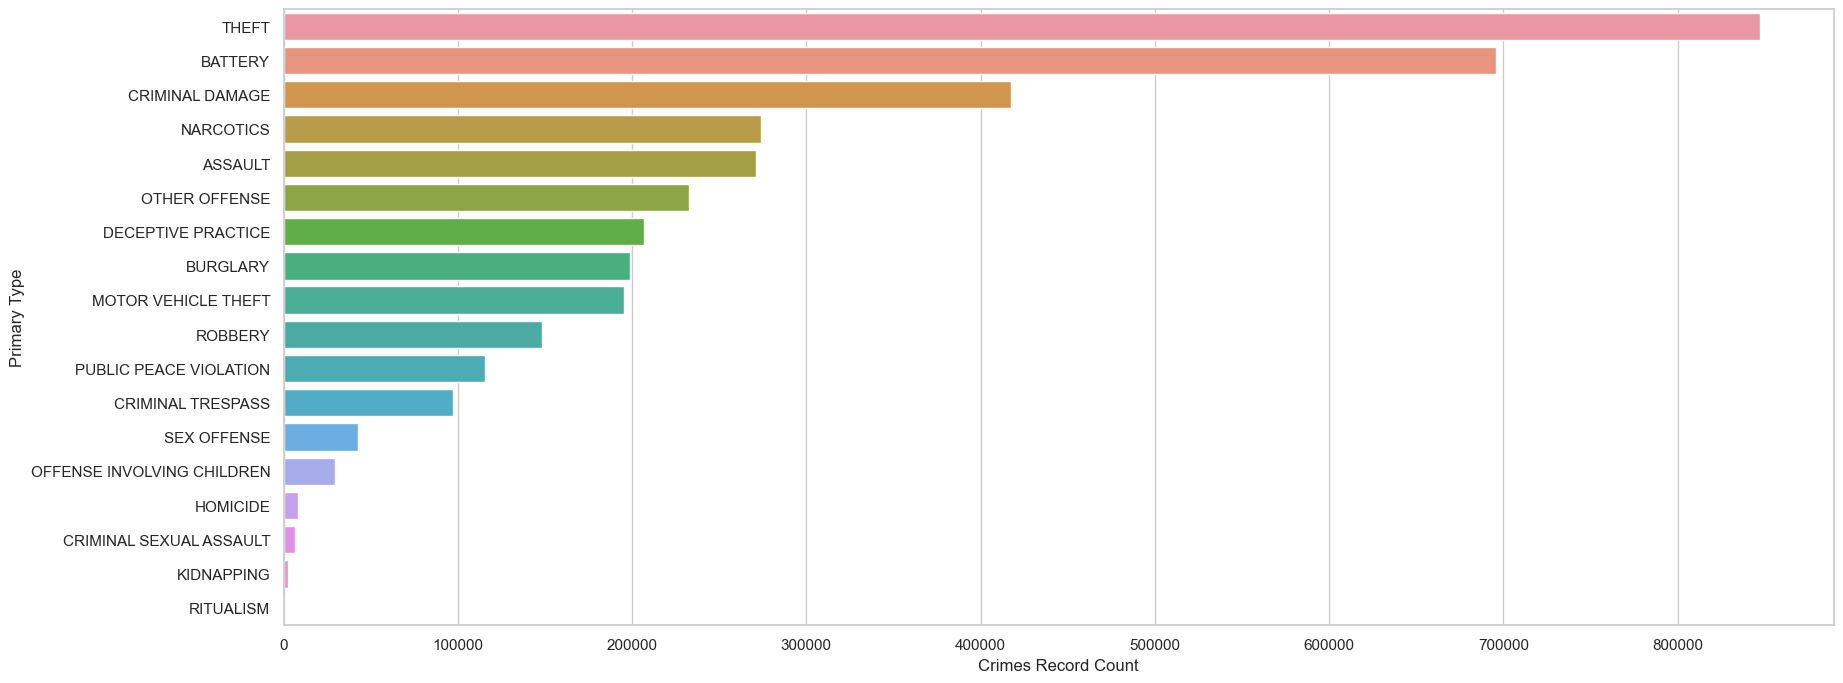

In [22]:
plt.rcParams["figure.figsize"] = [20, 8]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

#sns.despine(left=True, bottom=True)
type_graph = sns.barplot(x='count', y='primary_type', data=counts_pddf)
type_graph.set(ylabel="Primary Type", xlabel="Crimes Record Count")

### Recorded Date

In [23]:
import datetime
from pyspark.sql.functions import *

In [24]:
df.select(min('date').alias('first_record_date'), max('date').alias('latest_record_date')).show(truncate=False)

+----------------------+----------------------+
|first_record_date     |latest_record_date    |
+----------------------+----------------------+
|01/01/2010 01:00:00 AM|12/31/2022 12:52:00 PM|
+----------------------+----------------------+



So it seems that the dataset we're dealing with comprises records from **2010-01-01** to **2022-12-31**

---
Converting dates to a timestamp type. As seen in the schema output above, the `date` field is of `string` type, which won't be very helpful

The format specifier that seems valid for date like '02/23/2006 09:06:22 PM' is **`'MM/dd/yyyy hh:mm:ss a'`**

In [25]:
df.head(5)

[Row(date='09/06/2023 05:00:00 PM', block='002XX N Wells st', primary_type='CRIMINAL DAMAGE', location_description='PARKING LOT / GARAGE (NON RESIDENTIAL)', arrest=False, beat=122, district=1, ward=42, community_area=32, year=2023, latitude=41.886018055, longitude=-87.633937881, Day=datetime.date(2023, 9, 6), Month=9, WeekDay=4),
 Row(date='08/31/2023 12:00:00 PM', block='023XX W JACKSON BLVD', primary_type='DECEPTIVE PRACTICE', location_description='STREET', arrest=False, beat=1225, district=12, ward=27, community_area=28, year=2023, latitude=41.877565108, longitude=-87.68479102, Day=datetime.date(2023, 8, 31), Month=8, WeekDay=5),
 Row(date='07/24/2023 09:45:00 PM', block='073XX S JEFFERY BLVD', primary_type='CRIMINAL SEXUAL ASSAULT', location_description='APARTMENT', arrest=False, beat=333, district=3, ward=7, community_area=43, year=2023, latitude=41.7619185, longitude=-87.576209245, Day=datetime.date(2023, 7, 24), Month=7, WeekDay=2),
 Row(date='08/27/2023 07:00:00 AM', block='034

In [26]:
df = df.withColumn('date_time', F.to_timestamp('date', 'MM/dd/yyyy hh:mm:ss a'))\
       .withColumn('month', F.trunc('date_time', 'YYYY')) #adding a month column to be able to view stats on a monthly basis

In [27]:
df.select(['date','date_time', 'month'])\
  .show(n=5, truncate=False)

+----------------------+-------------------+----------+
|date                  |date_time          |month     |
+----------------------+-------------------+----------+
|09/06/2023 05:00:00 PM|2023-09-06 17:00:00|2023-01-01|
|08/31/2023 12:00:00 PM|2023-08-31 12:00:00|2023-01-01|
|07/24/2023 09:45:00 PM|2023-07-24 21:45:00|2023-01-01|
|08/27/2023 07:00:00 AM|2023-08-27 07:00:00|2023-01-01|
|09/04/2023 09:30:00 PM|2023-09-04 21:30:00|2023-01-01|
+----------------------+-------------------+----------+
only showing top 5 rows



### Primary type and arrest

In [28]:
# crime types and arrest over years:
type_arrest_date = df.groupBy(['arrest', 'month'])\
                     .count()\
                     .orderBy(['month', 'count'], ascending=[True, False])
print()
type_arrest_date.show(6, truncate=False)

+------+----------+------+
|arrest|month     |count |
+------+----------+------+
|false |2010-01-01|268955|
|true  |2010-01-01|98708 |
|false |2011-01-01|254398|
|true  |2011-01-01|94696 |
|false |2012-01-01|244220|
|true  |2012-01-01|89167 |
+------+----------+------+
only showing top 6 rows



In [29]:
# A small detour to learn/see how datetime works
import datetime

In [30]:
datetime.datetime.now()
datetime.datetime.strftime(datetime.datetime.now(), '%H')

'01'

In [31]:
# A pandas data frame of the collected dictionary version of the date-grouped DF above
type_arrest_pddf = pd.DataFrame(type_arrest_date.rdd.map(lambda l: l.asDict()).collect())

Convert date/time values to Pandas type

*A lot of this is unnecessary, but that's called fiddling...*

In [32]:
type_arrest_pddf['yearpd'] = type_arrest_pddf['month'].apply(lambda dt: datetime.datetime.strftime(pd.Timestamp(dt), '%Y'))

In [35]:
#type_arrest_pddf['arrest'] = type_arrest_pddf['arrest'].apply(lambda l: l=='True')
type_arrest_pddf.head(5)

,arrest,month,count,yearpd
0,False,2010-01-01,268955,2010
1,True,2010-01-01,98708,2010
2,False,2011-01-01,254398,2011
3,True,2011-01-01,94696,2011
4,False,2012-01-01,244220,2012


### How have arrests evolved over the 16 years?

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

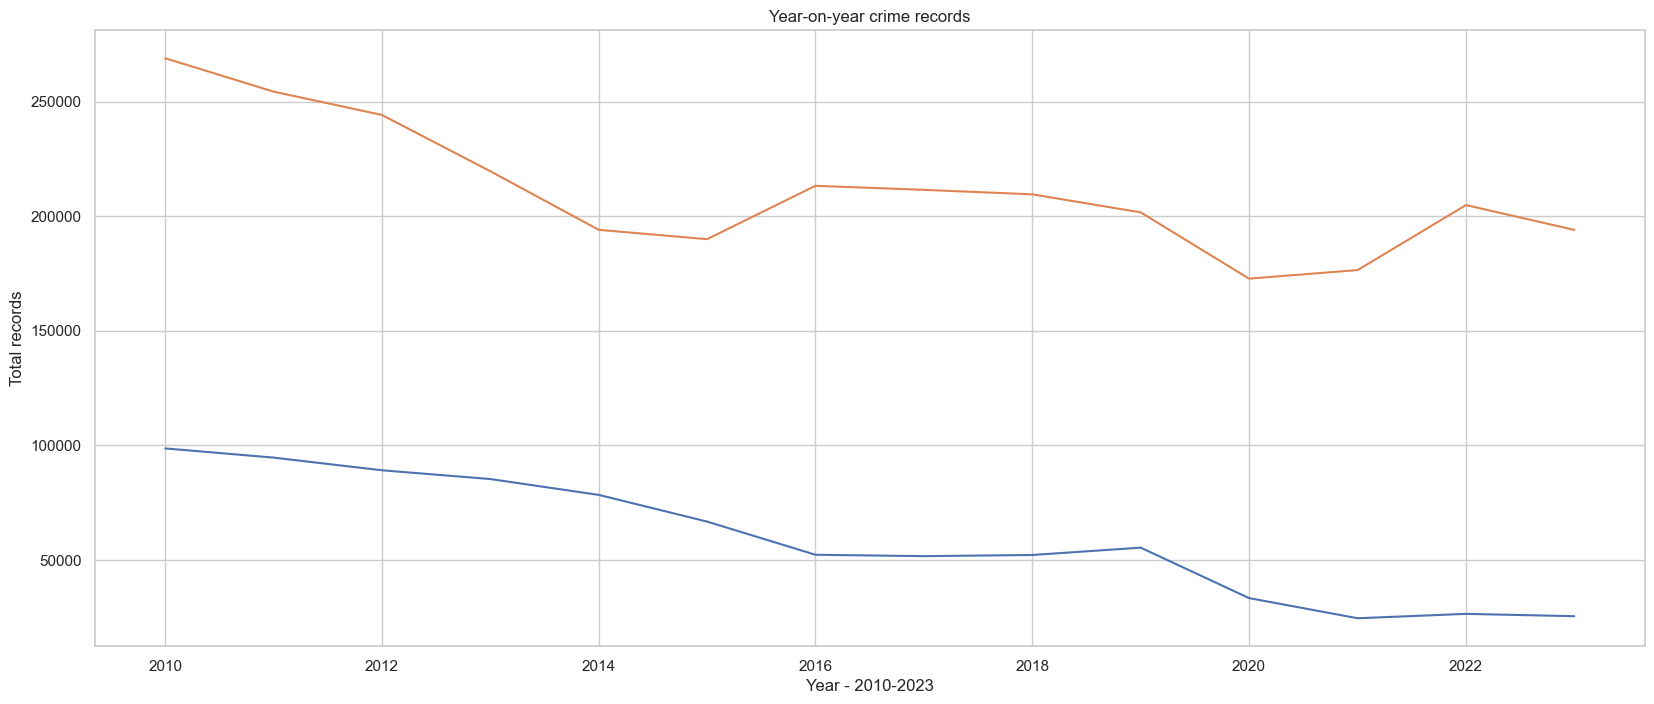

In [36]:
# Data for plotting
t = type_arrest_pddf['count'] - 20 # np.arange(0.0, 2.0, 0.01)
s = type_arrest_pddf['month']

arrested = type_arrest_pddf[type_arrest_pddf['arrest'] == True]
not_arrested = type_arrest_pddf[type_arrest_pddf['arrest'] == False]

# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()
ax.plot(arrested['month'], arrested['count'], label='Arrested')
ax.plot(not_arrested['month'], not_arrested['count'], label='Not Arrested')

ax.set(xlabel='Year - 2010-2023', ylabel='Total records',
       title='Year-on-year crime records')
ax.grid(b=True, which='both', axis='y')
ax.legend()

It looks like the relative distance between arrests and non-arrests has remained constant..

### What time of the day are criminal the busiest?

In [37]:
df.head(1)

[Row(date='09/06/2023 05:00:00 PM', block='002XX N Wells st', primary_type='CRIMINAL DAMAGE', location_description='PARKING LOT / GARAGE (NON RESIDENTIAL)', arrest=False, beat=122, district=1, ward=42, community_area=32, year=2023, latitude=41.886018055, longitude=-87.633937881, Day=datetime.date(2023, 9, 6), month=datetime.date(2023, 1, 1), WeekDay=4, date_time=datetime.datetime(2023, 9, 6, 17, 0))]

In [38]:
# Extract the "hour" field from the date into a separate column called "hour"
print(df['date_time'])
df_hour = df.withColumn('hour', F.hour(df['date_time']))

Column<'date_time'>


In [39]:
df_hour.head(5)

[Row(date='09/06/2023 05:00:00 PM', block='002XX N Wells st', primary_type='CRIMINAL DAMAGE', location_description='PARKING LOT / GARAGE (NON RESIDENTIAL)', arrest=False, beat=122, district=1, ward=42, community_area=32, year=2023, latitude=41.886018055, longitude=-87.633937881, Day=datetime.date(2023, 9, 6), month=datetime.date(2023, 1, 1), WeekDay=4, date_time=datetime.datetime(2023, 9, 6, 17, 0), hour=17),
 Row(date='08/31/2023 12:00:00 PM', block='023XX W JACKSON BLVD', primary_type='DECEPTIVE PRACTICE', location_description='STREET', arrest=False, beat=1225, district=12, ward=27, community_area=28, year=2023, latitude=41.877565108, longitude=-87.68479102, Day=datetime.date(2023, 8, 31), month=datetime.date(2023, 1, 1), WeekDay=5, date_time=datetime.datetime(2023, 8, 31, 12, 0), hour=12),
 Row(date='07/24/2023 09:45:00 PM', block='073XX S JEFFERY BLVD', primary_type='CRIMINAL SEXUAL ASSAULT', location_description='APARTMENT', arrest=False, beat=333, district=3, ward=7, community_ar

In [40]:
# Derive a data frame with crime counts per hour of the day:
hourly_count = df_hour.groupBy(['primary_type', 'hour']).count().cache()
hourly_total_count = hourly_count.groupBy('hour').sum('count')

In [41]:
hourly_count_pddf = pd.DataFrame(hourly_total_count.select(hourly_total_count['hour'], hourly_total_count['sum(count)'].alias('count'))\
                                .rdd.map(lambda l: l.asDict())\
                                 .collect())

In [42]:
hourly_count_pddf = hourly_count_pddf.sort_values(by='hour')

Seems that 18-22 are the worst hours...

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

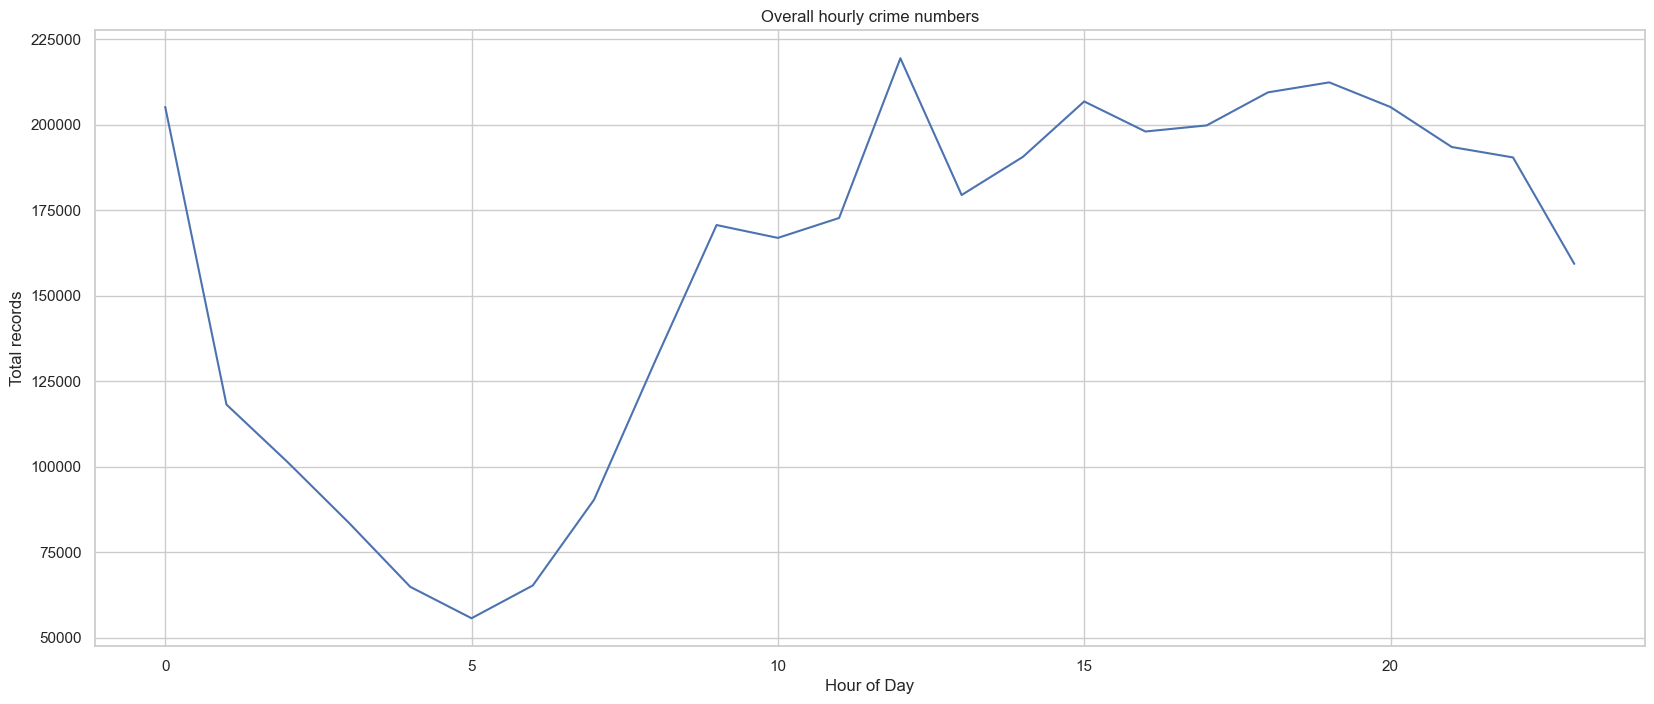

In [43]:
fig, ax = plt.subplots()
ax.plot(hourly_count_pddf['hour'], hourly_count_pddf['count'], label='Hourly Count')

ax.set(xlabel='Hour of Day', ylabel='Total records',
       title='Overall hourly crime numbers')
ax.grid(b=True, which='both', axis='y')
ax.legend()

### Types of locations with crime entries

In [44]:
# Number of types of location recorded in the dataset
df.select('location_description').distinct().count()

205

What are the top 10 places where crime occurred?

In [45]:
df.groupBy(['location_description']).count().orderBy('count', ascending=False).show(10)

+--------------------+------+
|location_description| count|
+--------------------+------+
|              STREET|912937|
|           RESIDENCE|603867|
|           APARTMENT|531806|
|            SIDEWALK|351110|
|               OTHER|111923|
|PARKING LOT/GARAG...| 86044|
|  SMALL RETAIL STORE| 85136|
|               ALLEY| 82154|
|          RESTAURANT| 72466|
|VEHICLE NON-COMME...| 62804|
+--------------------+------+
only showing top 10 rows



Can we see how the top crime locations are affected over the day?

In [46]:
#Being on the street and at home
street_home_hour = df.where((df['location_description'] == 'STREET') | (df['location_description'] == 'RESIDENCE'))

In [47]:
street_home_hour

DataFrame[date: string, block: string, primary_type: string, location_description: string, arrest: boolean, beat: int, district: int, ward: int, community_area: int, year: int, latitude: double, longitude: double, Day: date, month: date, WeekDay: int, date_time: timestamp]

In [48]:
#a data frame with location descriptions and counts of recorded crimes, and hours...
street_home_hour_pddf = pd.DataFrame(street_home_hour.rdd.map(lambda row: row.asDict()).collect())

# 

In [49]:
street_home_hour_pddf.head(5)
# street_home_hour_pddf = street_home_hour_pddf.sort_values(street_home_hour_pddf.date_time)
#street_home_hour_pddf[hour]

,date,block,primary_type,location_description,arrest,beat,district,ward,community_area,year,latitude,longitude,Day,month,WeekDay,date_time
0,08/31/2023 12:00:00 PM,023XX W JACKSON BLVD,DECEPTIVE PRACTICE,STREET,False,1225,12,27,28,2023,41.877565,-87.684791,2023-08-31,2023-01-01,5,2023-08-31 12:00:00
1,08/17/2023 07:00:00 AM,019XX W 71ST ST,THEFT,STREET,False,735,7,17,67,2023,41.764827,-87.671709,2023-08-17,2023-01-01,5,2023-08-17 07:00:00
2,08/11/2023 11:00:00 AM,0000X S ALBANY AVE,OFFENSE INVOLVING CHILDREN,RESIDENCE,False,1124,11,28,27,2023,41.880594,-87.702959,2023-08-11,2023-01-01,6,2023-08-11 11:00:00
3,04/21/2019 12:30:00 PM,009XX E 80TH ST,ROBBERY,RESIDENCE,False,631,6,8,44,2019,41.749500,-87.601157,2019-04-21,2019-01-01,1,2019-04-21 12:30:00
4,10/30/2020 04:30:00 PM,011XX E 82ND ST,CRIMINAL SEXUAL ASSAULT,RESIDENCE,True,411,4,8,45,2020,41.745883,-87.597168,2020-10-30,2020-01-01,6,2020-10-30 16:30:00


### A closer look at crime date and time

The information given here indicates when the crime is perpetrated. The date/time field may be able to draw a meaningful trend that can be used to predict crime. However, I believe that this leads much more to external factors, such as policy changes, law inforcement-related factors, and so on.

It's much more likely that time-related features that are more closely relatable to crime occurence be better predictors than the date and time. I mean, knowing the month of the year, the day of the week, and the hour of the day that the crime occurred can enable better chances of predicting accurately than simply knowing "when" AD crimes occurred.

Adding predictors (so far fields) that read time information:

 * hour of day (already added the 'hour' field)
 * day of week
 * month of year
 * day in a range. Instead of using the entire date-time, we'll use a "day sequence" that is counted from 2001-01-01.

In [50]:
df_hour.head(5)

[Row(date='09/06/2023 05:00:00 PM', block='002XX N Wells st', primary_type='CRIMINAL DAMAGE', location_description='PARKING LOT / GARAGE (NON RESIDENTIAL)', arrest=False, beat=122, district=1, ward=42, community_area=32, year=2023, latitude=41.886018055, longitude=-87.633937881, Day=datetime.date(2023, 9, 6), month=datetime.date(2023, 1, 1), WeekDay=4, date_time=datetime.datetime(2023, 9, 6, 17, 0), hour=17),
 Row(date='08/31/2023 12:00:00 PM', block='023XX W JACKSON BLVD', primary_type='DECEPTIVE PRACTICE', location_description='STREET', arrest=False, beat=1225, district=12, ward=27, community_area=28, year=2023, latitude=41.877565108, longitude=-87.68479102, Day=datetime.date(2023, 8, 31), month=datetime.date(2023, 1, 1), WeekDay=5, date_time=datetime.datetime(2023, 8, 31, 12, 0), hour=12),
 Row(date='07/24/2023 09:45:00 PM', block='073XX S JEFFERY BLVD', primary_type='CRIMINAL SEXUAL ASSAULT', location_description='APARTMENT', arrest=False, beat=333, district=3, ward=7, community_ar

In [51]:

df_dates = df_hour.withColumn('week_day', F.dayofweek(df_hour['date_time']))\
                 .withColumn('year_month', F.month(df_hour['date_time']))\
                 .withColumn('month_day', F.dayofmonth(df_hour['date_time']))\
                 .withColumn('date_number', F.datediff(df['date_time'], F.to_date(F.lit('2010-01-01'), format='yyyy-MM-dd')))\
                 .cache()

In [52]:
df_dates.select(['date', 'month', 'hour', 'week_day', 'year', 'year_month', 'month_day', 'date_number']).show(20, truncate=False)

23/11/16 01:47:26 WARN MemoryStore: Not enough space to cache rdd_165_8 in memory! (computed 13.9 MiB so far)
23/11/16 01:47:26 WARN MemoryStore: Not enough space to cache rdd_165_1 in memory! (computed 14.2 MiB so far)
23/11/16 01:47:26 WARN MemoryStore: Not enough space to cache rdd_165_13 in memory! (computed 14.4 MiB so far)
23/11/16 01:47:26 WARN MemoryStore: Not enough space to cache rdd_165_3 in memory! (computed 14.1 MiB so far)
23/11/16 01:47:26 WARN BlockManager: Persisting block rdd_165_3 to disk instead.
23/11/16 01:47:26 WARN BlockManager: Persisting block rdd_165_13 to disk instead.
23/11/16 01:47:26 WARN BlockManager: Persisting block rdd_165_8 to disk instead.
23/11/16 01:47:26 WARN BlockManager: Persisting block rdd_165_1 to disk instead.
23/11/16 01:47:26 WARN MemoryStore: Not enough space to cache rdd_165_0 in memory! (computed 13.2 MiB so far)
23/11/16 01:47:26 WARN BlockManager: Persisting block rdd_165_0 to disk instead.
23/11/16 01:47:26 WARN MemoryStore: Not eno

+----------------------+----------+----+--------+----+----------+---------+-----------+
|date                  |month     |hour|week_day|year|year_month|month_day|date_number|
+----------------------+----------+----+--------+----+----------+---------+-----------+
|09/06/2023 05:00:00 PM|2023-01-01|17  |4       |2023|9         |6        |4996       |
|08/31/2023 12:00:00 PM|2023-01-01|12  |5       |2023|8         |31       |4990       |
|07/24/2023 09:45:00 PM|2023-01-01|21  |2       |2023|7         |24       |4952       |
|08/27/2023 07:00:00 AM|2023-01-01|7   |1       |2023|8         |27       |4986       |
|09/04/2023 09:30:00 PM|2023-01-01|21  |2       |2023|9         |4        |4994       |
|08/15/2023 02:20:00 PM|2023-01-01|14  |3       |2023|8         |15       |4974       |
|07/24/2023 04:09:00 PM|2023-01-01|16  |2       |2023|7         |24       |4952       |
|09/03/2023 10:27:00 AM|2023-01-01|10  |1       |2023|9         |3        |4993       |
|08/17/2023 07:00:00 AM|2023-01-

## Day of week crime levels

It seems intriguing that the're little variance... But bad people are bad all week, aren't they...

In [53]:
week_day_crime_counts = df_dates.groupBy('week_day').count()

In [54]:
week_day_crime_counts_pddf = pd.DataFrame(week_day_crime_counts.orderBy('week_day').rdd.map(lambda e: e.asDict()).collect())

<Axes: xlabel='week_day', ylabel='count'>

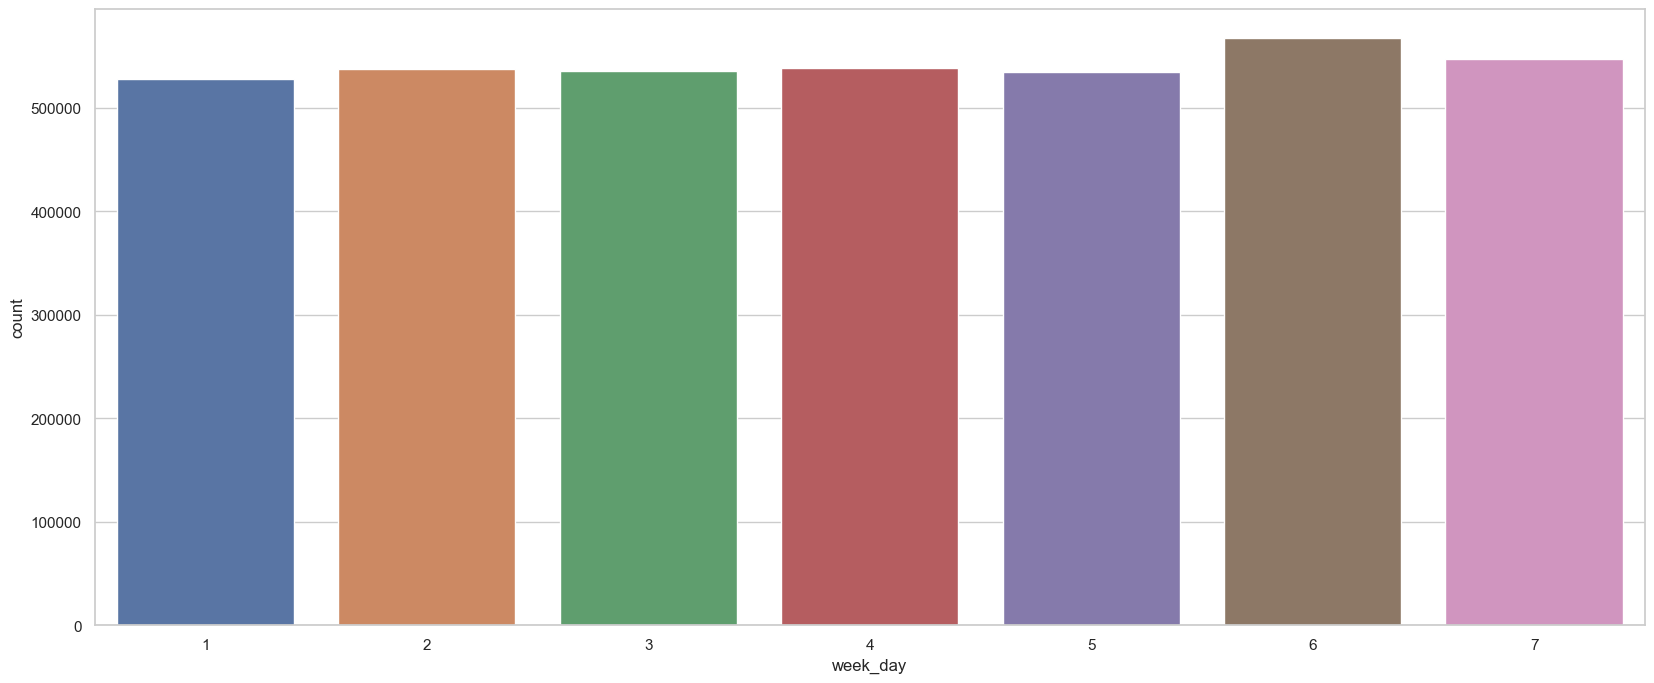

In [55]:
sns.barplot(data=week_day_crime_counts_pddf, x='week_day', y='count')

## Month of year

It seems that May-August are the busiest months for criminals... What could be the reason?

In [56]:
year_month_crime_counts = df_dates.groupBy('year_month').count()

In [57]:
year_month_crime_counts_pddf = pd.DataFrame(year_month_crime_counts.orderBy('year_month').rdd.map(lambda e: e.asDict()).collect())

In [58]:
year_month_crime_counts_pddf

,year_month,count
0,1,299874
1,2,262130
2,3,310180
3,4,305939
4,5,339927
5,6,342308
6,7,357285
7,8,354474
8,9,330881
9,10,331749


What happens in MAY through AUGUST?

 * Salary increase season?
 * Weather?

I think these don't form the Christmas season in Chicago...

<Axes: xlabel='year_month', ylabel='count'>

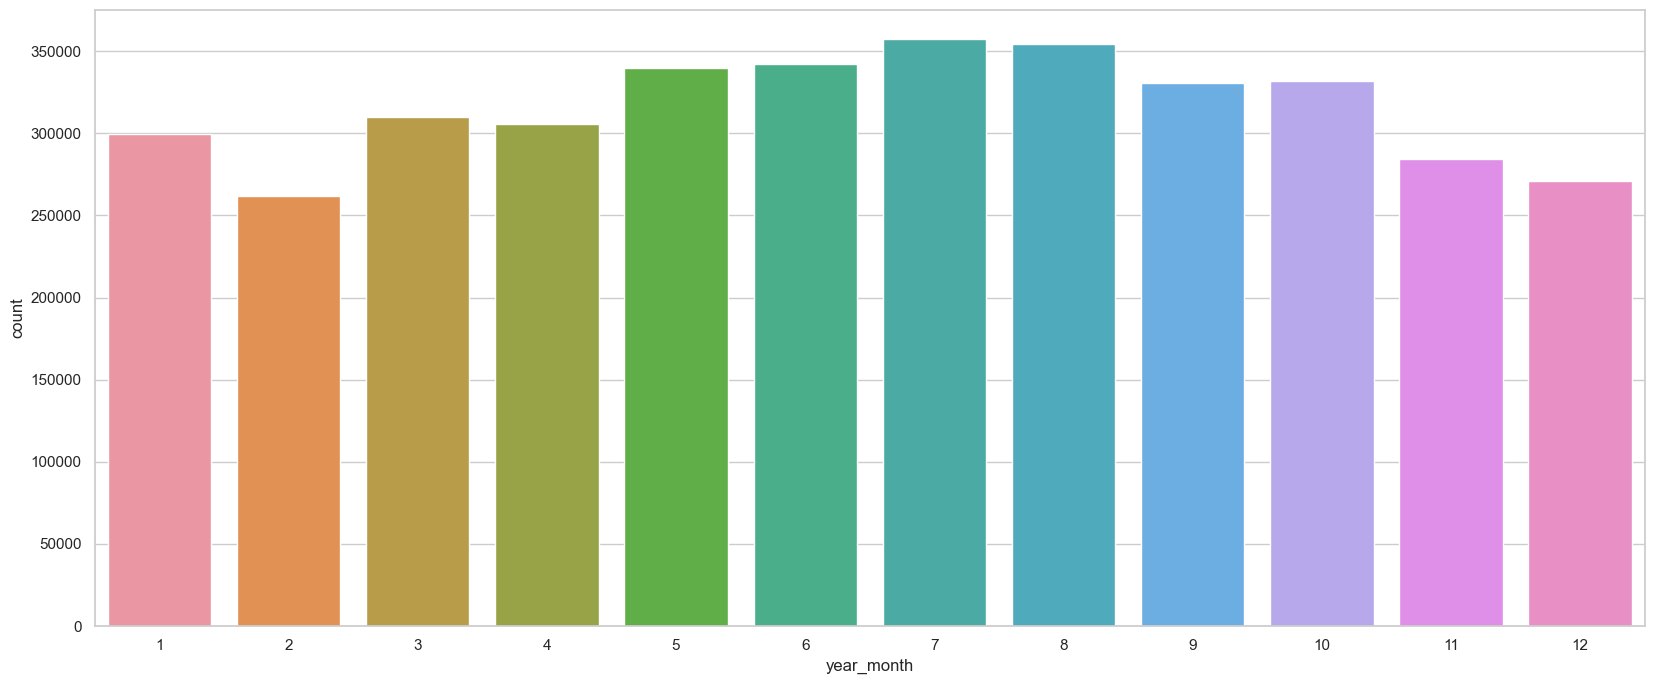

In [59]:
sns.barplot(data=year_month_crime_counts_pddf, y='count', x='year_month')

## Day of month

In [60]:
month_day_crime_counts = df_dates.groupBy('month_day').count()

In [61]:
month_day_crime_counts_pddf = pd.DataFrame(month_day_crime_counts.orderBy('month_day').rdd.map(lambda e: e.asDict()).collect())

#### Top 10 worst days of the month

In [62]:
month_day_crime_counts_pddf.sort_values(by='count', ascending=False).head(10)

,month_day,count
0,1,145678
14,15,127986
19,20,125821
16,17,125178
2,3,124946
15,16,124831
4,5,124801
3,4,124690
22,23,124571
9,10,124497


In [63]:
month_day_crime_counts_pddf = month_day_crime_counts_pddf.sort_values(by='month_day', ascending=True)

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

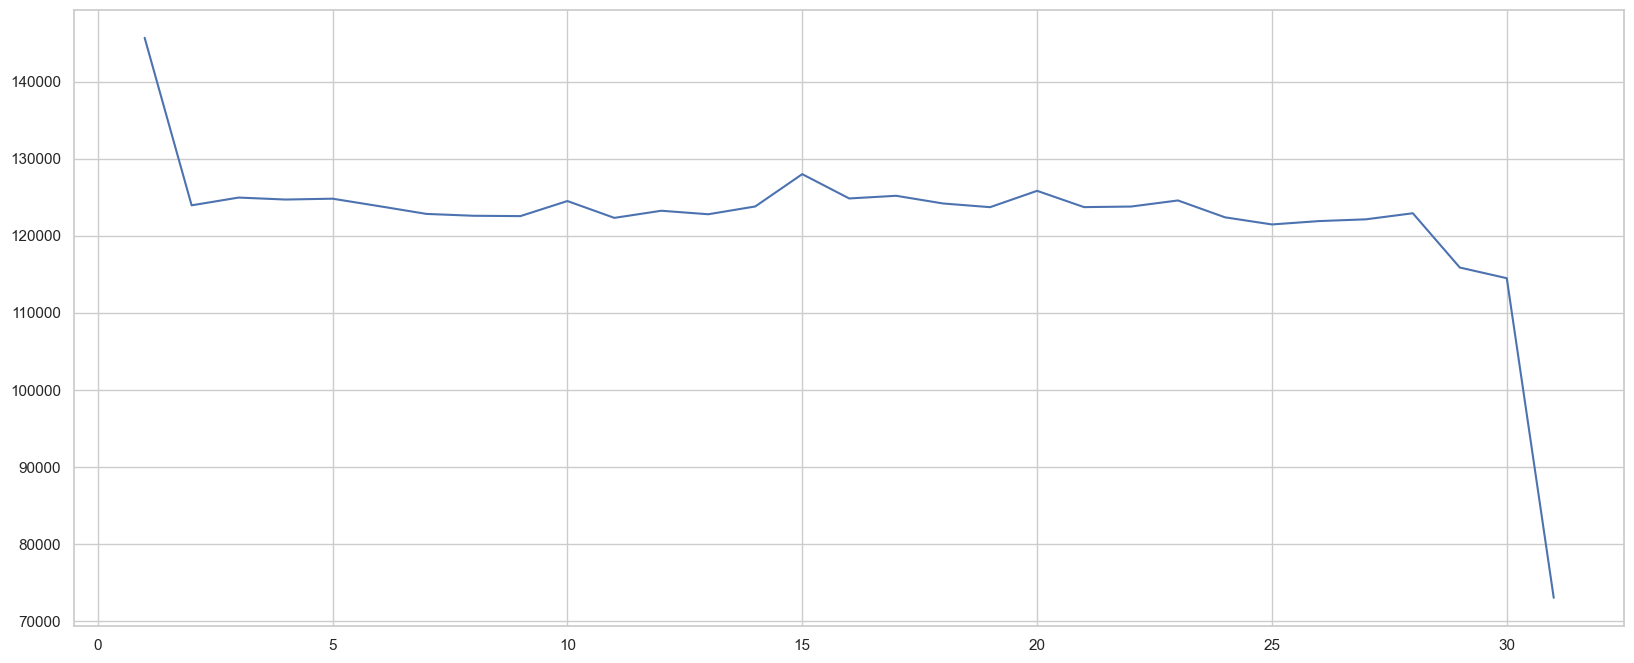

In [64]:
fg, ax = plt.subplots()

ax.plot(month_day_crime_counts_pddf['month_day'], month_day_crime_counts_pddf['count'], label='Crimes over the month')

ax.grid(b=True, which='both')
ax.legend()

### Community areas?

Chicago has 77 community areas. How do they appear next to one another in a count plot?

In [65]:
df_dates_community_areas = df_dates.na.drop(subset=['community_area']).groupBy('community_area').count()

What are the to 10 areas with recorded crime?

In [66]:
df_dates_community_areas.orderBy('count', ascending=False).show(10)

+--------------+------+
|community_area| count|
+--------------+------+
|            25|230938|
|             8|143405|
|            43|128832|
|            28|119953|
|            29|118565|
|            23|116907|
|            32|110953|
|            71|108086|
|            24|107830|
|            67|102009|
+--------------+------+
only showing top 10 rows



In [67]:
## Is it possible to see how the top crime types occur in the top crime-affected areas?
top_crime_types = df_dates.select('primary_type').groupBy('primary_type').count().rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])
top_busy_areas =  df_dates_community_areas.rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])

In [68]:
top_crime_types_lst = [dc['primary_type'] for dc in top_crime_types]
top_busy_areas_lst = [dc['community_area'] for dc in top_busy_areas]

In [69]:
top_crime_types_lst

['THEFT',
 'BATTERY',
 'CRIMINAL DAMAGE',
 'NARCOTICS',
 'ASSAULT',
 'OTHER OFFENSE',
 'DECEPTIVE PRACTICE',
 'BURGLARY',
 'MOTOR VEHICLE THEFT',
 'ROBBERY']

In [70]:
top_busy_areas_lst

[25, 8, 43, 28, 29, 23, 32, 71, 24, 67]

Find crimes of the top 10 types, that were perpetrated in the 10 10 busiest cities...

In [71]:
q1 = "instr('" + ' '.join(str(area) for area in top_busy_areas_lst) + "', community_area) > 0"
q2 = "instr('" + ' '.join(str(crime_type) for crime_type in top_crime_types_lst) + "', primary_type) > 0"
print(q1)

instr('25 8 43 28 29 23 32 71 24 67', community_area) > 0


In [72]:
## Construct a data frame filtered on these top community areas and top crime types:
df_dates_tops = df_dates.filter(q1).filter(q2)

In [73]:
df_dates_tops.count()

1516589

In [74]:
tops_of_tops = df_dates_tops.groupBy(['primary_type', 'community_area']).count().orderBy(['primary_type', 'count', 'community_area'], ascending=[True, False, True]).cache()

In [75]:
tops_of_tops.show(20)

+------------+--------------+-----+
|primary_type|community_area|count|
+------------+--------------+-----+
|     ASSAULT|            25|16799|
|     ASSAULT|            43|10772|
|     ASSAULT|            71| 9194|
|     ASSAULT|            29| 8733|
|     ASSAULT|            67| 8557|
|     ASSAULT|            23| 8238|
|     ASSAULT|            28| 7697|
|     ASSAULT|             8| 6216|
|     ASSAULT|            24| 5710|
|     ASSAULT|            32| 5088|
|     ASSAULT|             1| 4000|
|     ASSAULT|             3| 3863|
|     ASSAULT|             6| 3342|
|     ASSAULT|             2| 3254|
|     ASSAULT|             7| 1863|
|     ASSAULT|             4| 1609|
|     ASSAULT|             5|  882|
|     ASSAULT|             9|  232|
|     BATTERY|            25|48122|
|     BATTERY|            43|28832|
+------------+--------------+-----+
only showing top 20 rows



#### Community area names

Let's link names of these community areas. These float numbers are having a hard time making any sense...

Sourced from Chicago Tribune at http://www.chicagotribune.com/chi-community-areas-htmlstory.html


In [76]:
area_names = """
01	Rogers Park	
40	Washington Park
02	West Ridge	
41	Hyde Park
03	Uptown	
42	Woodlawn
04	Lincoln Square	
43	South Shore
05	North Center	
44	Chatham
06	Lakeview	
45	Avalon Park
07	Lincoln Park	
46	South Chicago
08	Near North Side	
47	Burnside
09	Edison Park	
48	Calumet Heights
10	Norwood Park	
49	Roseland
11	Jefferson Park	
50	Pullman
12	Forest Glen	
51	South Deering
13	North Park	
52	East Side
14	Albany Park	
53	West Pullman
15	Portage Park	
54	Riverdale
16	Irving Park	
55	Hegewisch
17	Dunning	
56	Garfield Ridge
18	Montclare	
57	Archer Heights
19	Belmont Cragin	
58	Brighton Park
20	Hermosa	
59	McKinley Park
21	Avondale	
60	Bridgeport
22	Logan Square	
61	New City
23	Humboldt Park	
62	West Elsdon
24	West Town	
63	Gage Park
25	Austin	
64	Clearing
26	West Garfield Park 	
65	West Lawn
27	East Garfield Park	
66	Chicago Lawn
28	Near West Side	
67	West Englewood
29	North Lawndale	
68	Englewood
30	South Lawndale	
69	Greater Grand Crossing
31	Lower West Side	
70	Ashburn
32	Loop	
71	Auburn Gresham	
33	Near South Side	
72	Beverly
34	Armour Square	
73	Washington Heights
35	Douglas	
74	Mount Greenwood
36	Oakland	
75	Morgan Park
37	Fuller Park	
76	O'Hare
38	Grand Boulevard	
77	Edgewater
39	Kenwood	
"""

In [77]:
code_pairs = [[float(p[0]), p[1]] for p in [pair.strip().split('\t') for pair in area_names.strip().split('\n')]]

In [78]:
code_pairs[:5]

[[1.0, 'Rogers Park'],
 [40.0, 'Washington Park'],
 [2.0, 'West Ridge'],
 [41.0, 'Hyde Park'],
 [3.0, 'Uptown']]

#### A view of crime count per community area

In [79]:
community_area_counts = pd.DataFrame(df_dates_community_areas.rdd.map(lambda row: row.asDict()).collect())

In [80]:
# Create a dictionary of area code to names
area_name_dic = {float(k[0]):k[1] for k in code_pairs}

In [81]:
community_area_counts['community_area_name'] = community_area_counts['community_area'].apply(lambda area: area_name_dic.get(float(area),  'unknown_%s'%area))

In [82]:
community_area_counts = community_area_counts.sort_values(by='count')
community_area_counts.head(5)

,community_area,count,community_area_name
74,0,9,unknown_0
31,9,3832,Edison Park
11,47,5482,Burnside
9,12,7270,Forest Glen
76,74,8353,Mount Greenwood


**What is happening in Austin?**

plt.rcParams["figure.figsize"] = [32, 32]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

#sns.despine(left=True, bottom=True)
area_chart = sns.barplot(x='count', y='community_area_name', data=community_area_counts)
area_chart.set(ylabel="Community Area Name", xlabel="Overall Crimes Record Count")

** *Join these community areas on the main data frame* **

In [83]:
code_pairs_df = spark.createDataFrame(code_pairs, ['community_area', 'area_name'])

In [84]:
named_tops_of_tops = code_pairs_df.join(tops_of_tops, on='community_area', how='right')

In [85]:
named_tops_of_tops.show(10)

+--------------+---------------+------------+-----+
|community_area|      area_name|primary_type|count|
+--------------+---------------+------------+-----+
|             1|    Rogers Park|     ASSAULT| 4000|
|             8|Near North Side|     ASSAULT| 6216|
|            23|  Humboldt Park|     ASSAULT| 8238|
|            24|      West Town|     ASSAULT| 5710|
|            25|         Austin|     ASSAULT|16799|
|            28| Near West Side|     ASSAULT| 7697|
|            29| North Lawndale|     ASSAULT| 8733|
|            32|           Loop|     ASSAULT| 5088|
|            43|    South Shore|     ASSAULT|10772|
|            67| West Englewood|     ASSAULT| 8557|
+--------------+---------------+------------+-----+
only showing top 10 rows



In [86]:
tops_of_tops_dff = pd.DataFrame(named_tops_of_tops.rdd.map(lambda l: l.asDict()).collect() )

<Axes: xlabel='area_name', ylabel='count'>

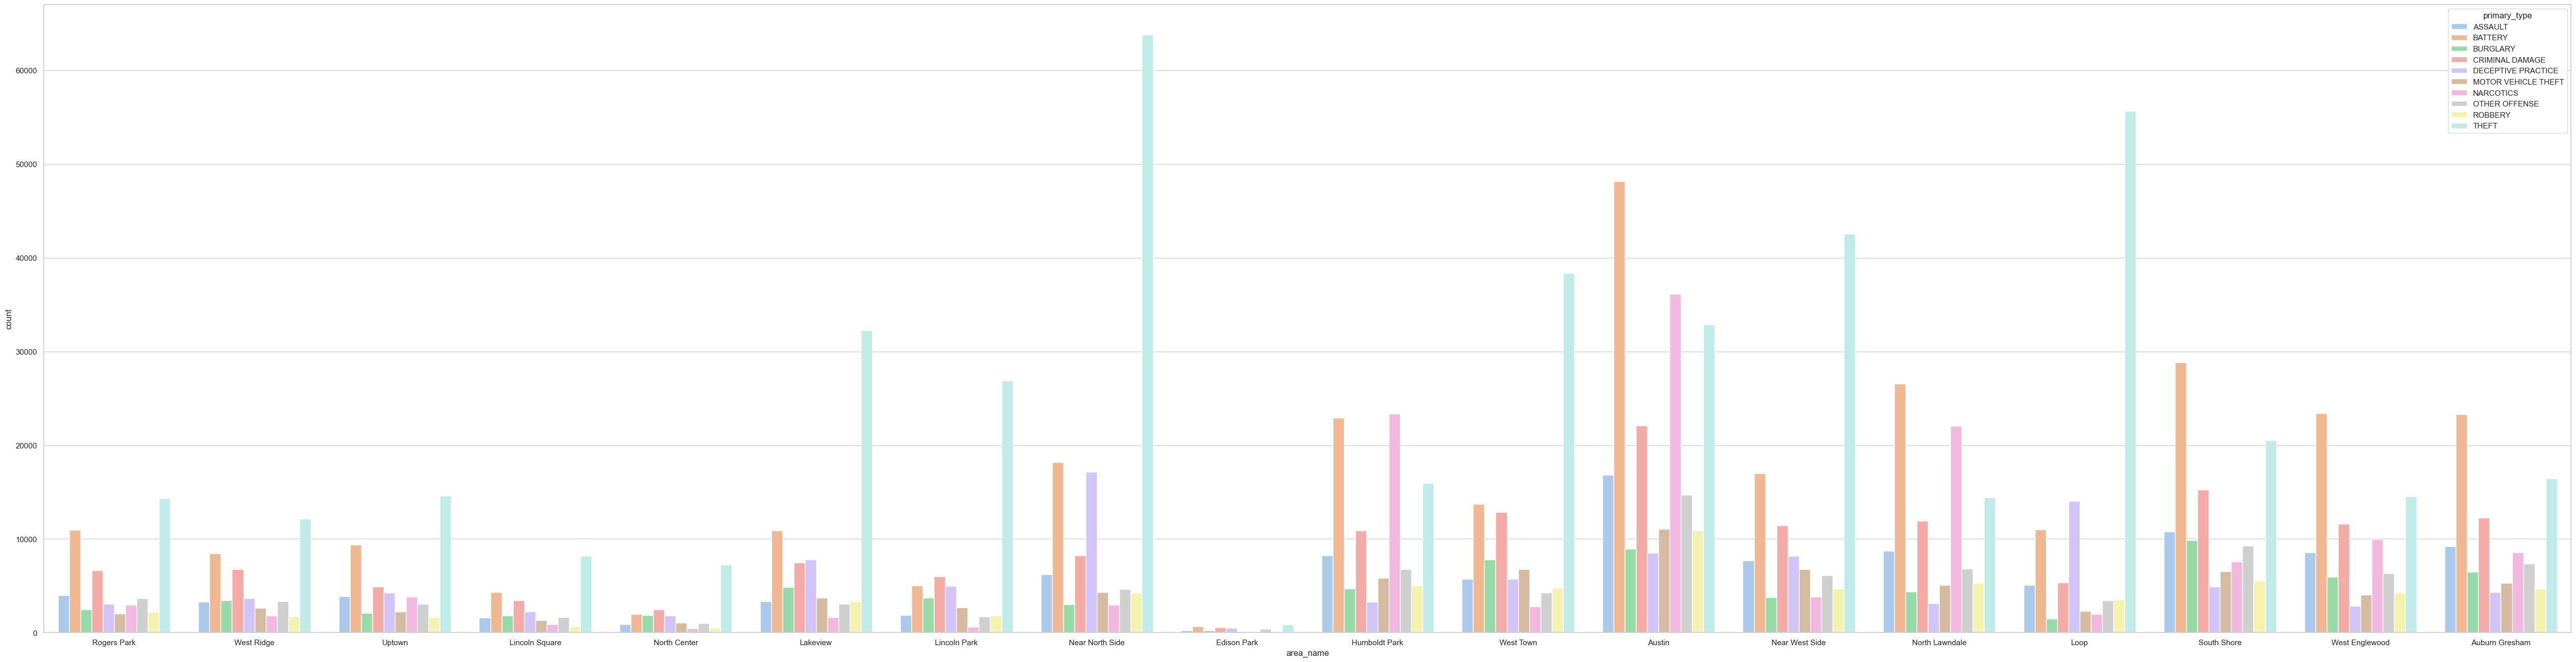

In [87]:
plt.rcParams["figure.figsize"] = [64, 16]
sns.barplot(data=tops_of_tops_dff, x='area_name', y='count', hue='primary_type', palette='pastel')